### Isolation Forest

Данный подход не требует нормальности данных (в смысле рабочего состояния системы), т.е. в данных могут быть аномалии. **Из-за своей склонности к изоляции аномалии изолируются ближе к корню дерева.** В то время как нормальные состояния системы находится как можно глубже. При моделировании строится ансамбль деревьев для предлагаемого датасета, тогда аномалии - это те экземпляры, которые имеют короткую среднюю длину пути. Существует два гиперпараметра модели: количество деревьев в лесу и размер подвыборки.

Изолировать - это значит отделить один объект от остальных. Аномалии наиболее предрасположены к изоляции, поскольку их мало и они отличаются от нормальных объектов. В случайном дереве разбиение экземпляров рекурсивно повторяется до тех пор, пока все экземпляры не будут изолированы. Если лес случайных деревьев вместе создает более короткие пути для некоторых конкретных точек, то они, скорее всего, будут аномалиями. 

Нормальный объект требует больших разбиений для того чтобы быть изолированным, в то время как аномальный объект будет отделен на более ранней стадии. **При разбиении рандомно выбирается признак и сплит-значение** между минимальным и максимальным значениями признака.

Поскольку рекурсивное разбиение может быть представлено в деревовидной структуре, то количество разбиений соответсвует длине пути из корня в терминальную вершину. Поскольку каждое разбиение рандомно, то в отдельности деревья сгенерируют различные разбиения. Тогда для каждой вершины посмотрим его высоту в дереве и усредним по рамеру леса. При увеличении количества деревьев средняя высота будет сходиться к конкретному числу.

<img src="./img/iforest_process.png" alt="Drawing" style="width: 400px; height: 600px"/>

На картинках видно, что аномалия довольно быстро отсекается, и чем больше деревьев в ансамбле тем конкретнее длина пути

**Определение Isolation Tree**. Пусть $T$ это произвольная вершина. Тогда $T$ это либо внешняя вершина без детей, либо внутрення с двумя детьми $(T_l, T_r)$ и *тестом*. Тест содержит значения признака $q$ и сплит-значение $p$, и по критерию $q < p$ разделяет данные в $T_l$ и $T_r$ соответственно.

Пусть дана выборка $X = \{x_1, x_2, \ldots, x_n\}$, тогда для построения модели будем рекурсивно разделять выборку по рандомному признаку $q$ и сплит-значению $p$ до тех пор пока:
* не будет достигнут лимит по высоте дерева (как гиперпараметр модели)
* размер выборки не будет равняться единице $|X| = 1$
* все объекты в выборке не будут иметь одинаковые значения

Isolation Tree это бинарное дерево, т.е. каждая вершина имеет не больше двух дочерних вершин. Чтобы обнаружить аномалии нужно отсортировать вершины по длине пути или *anomaly score* в порядке возрастания, тогда вверху списка будут аномальные вершины.

**Длина пути и anomaly score**. Длина пути $h(x)$ это просто количество ребер от корня дерева до вершины $x$.

Поскольку $ITree$ имеет аналогичную структуру, что и $BST$ (двоичное дерево поиска), то средняя длина внешнего пути оценивается как [неудачный поиск в BST](https://book.huihoo.com/data-structures-and-algorithms-with-object-oriented-design-patterns-in-java/html/page308.html), а здесь [более подробно про связь с гармоническими числами](https://www.cs.csustan.edu/~john/classes/previous_semesters/cs3100_datastructures/2000_04_Fall/Examples/Trees/averageSearchInBST.html). Откуда можно получить среднюю глубину внешней вершины
$$\large c(n) = 2H(n-1) - \frac{2(n-1)}{n}$$

Поскольку $c(n)$ это среднее значение, то можно использовать его для нормализации $h(x)$. Таким образом *anomaly score* для объекта $x$ определяется как $$\Large s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

где $E(h(x))$ это средняя длина пути для объекта $x$ на основе всех деревьев

<img src="./img/iforest_score.png" alt="Drawing" style="width: 400px; height: 300px"/>

Из графика видно, чем чем больше $E(h(x))$ относительно $c(n)$ тем ближе *anomaly score* к нулю и тем менее вероятно что объект $x$ является аномалией. И наоборот. Поэтому можно сделать несколько важных выводов:

* если значение близко к единице, то это определенно аномалия
* если объекты имеют значение $< 0.5$, то их можно рассматривать как нормальные

Как ансамбль деревьев, в котором используются изолированные деревья, IForest а) идентифицирует аномалии как точки с более короткой длиной пути и б) имеет несколько деревьев, действующих как «эксперты» для выявления различных аномалий. Поскольку IForest не нужно изолировать все нормальные экземпляры — большую часть обучающей выборки IForest может хорошо работать с частичной моделью, не изолируя все нормальные точки, и строит модели, используя небольшой размер выборки. При этом большой размер выборки снижает способность IForest изолировать аномалии, поскольку обычные экземпляры могут мешать процессу изоляции и, следовательно, уменьшают его способность однозначно изолировать аномалии. 

**Основые проблемы при поиске аномалий**: *swamping* и *masking*. 

*Swamping* относится к ошибочной идентификации нормальных экземпляров как аномалий (оно же ложноположительное обнаружение). Когда нормальные экземпляры находятся слишком близко к аномалиям, количество разделов, необходимых для разделения аномалий, увеличивается, что затрудняет отличить аномалии от нормальных экземпляров. 

*Masking* это наличие слишком большого количества аномалий (групповые аномалии), скрывающих свое присутствие. Когда кластер аномалий большой и плотный, также увеличивается количество разделов для изоляции каждой аномалии. 

В этих обстоятельствах оценки с использованием $Itrees$ имеют большую длину пути, что и затрудняет обнаружение аномалий. Обе проблемы вытекают из слишком большого размера выборки. Способность $IForest$ работать с частичной моделью позволяет избежать этих проблем, и этим нужно пользоваться. Это связано с тем, что: 1) подвыборка контролирует размер данных, что помогает IForest лучше изолировать аномалии и 2) каждое изолированное дерево может быть специализировано, поскольку каждая подвыборка включает различный набор аномалий или даже не содержит аномалий. 

###  Обнаружение аномалий с помощью IForest

Алгоритм состоит из двух стадий, как в классическом машинном обучении. Первая стадия - тренировка, строит $ITrees$ на подвыборках из тренировочных данных. На второй стадии - тестирование, тестовые экземпляры проходят через деревья изоляции, чтобы получить оценку аномалии для каждого экземпляра.

**Если в выборке большая доля аномалий, лучше обучаться только на здоровых данных.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

from utils.metrics import mar, far, f1_score
from utils.data import load_df

## Seed fixation

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

# Fitting

In [3]:
from sklearn.ensemble import IsolationForest
from ipywidgets import IntProgress
from IPython.display import display
from utils.pipeline import Pipeline, Predictor

In [4]:
class Config:
    train_size = 400
    n_estimators = 100
    contamination = 0.05
    
conf = Config

class IForest_Predictor(Predictor):
    def make_prediction(self, df):
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        conf.train_size = first_anomaly_idx
        df = df.drop(["anomaly", "changepoint"], axis=1)
        
        clf = IsolationForest(n_estimators=conf.n_estimators,
                              contamination=conf.contamination, 
                              n_jobs=-1, random_state=seed_value)
        
        clf.fit(df.values[:conf.train_size])
        prediction_raw = clf.predict(df.values)
        prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        return prediction

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5327398615232443

FAR = 0.0934942198970551

MAR = 0.5731494690125218

Anomaly: valve2


IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6171641791044776

FAR = 0.12021466905187836

MAR = 0.45484508899143045

Anomaly: other0


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7838125665601704

FAR = 0.16238159675236807

MAR = 0.18403547671840353

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8130745658835546

FAR = 0.24226110363391656

MAR = 0.007481296758104738

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5198463508322664

FAR = 0.22550335570469798

MAR = 0.5048780487804878

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7128712871287128

FAR = 0.1975642760487145

MAR = 0.18446601941747573

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.08360128617363344

FAR = 0.05015197568389058

MAR = 0.9509433962264151

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.4807692307692308

FAR = 0.10284167794316644

MAR = 0.6231155778894473

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8

FAR = 0.05026929982046679

MAR = 0.23404255319148937

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8174123337363967

FAR = 0.1911170928667564

MAR = 0.025936599423631124

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8015810276679842

FAR = 0.2321187584345479

MAR = 0.1348122866894198

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.878125

FAR = 0.0945273631840796

MAR = 0.0695364238410596

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5667215815485996

FAR = 0.05025125628140704

MAR = 0.5645569620253165

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8185745140388769

FAR = 0.19463087248322147

MAR = 0.05721393034825871

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5289672544080605

FAR = 0.24327956989247312

MAR = 0.47890818858560796

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7123287671232876

FAR = 0.6919191919191919

MAR = 0.052083333333333336



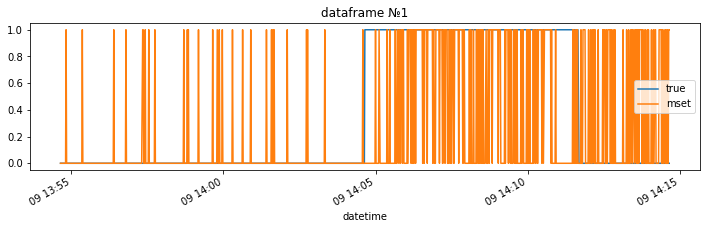

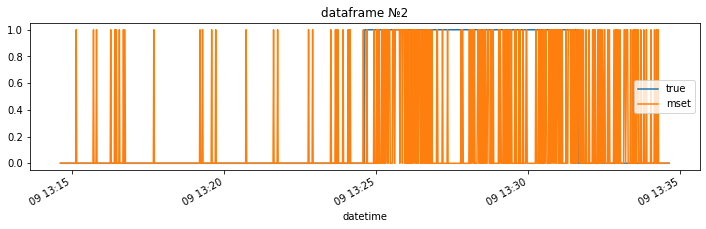

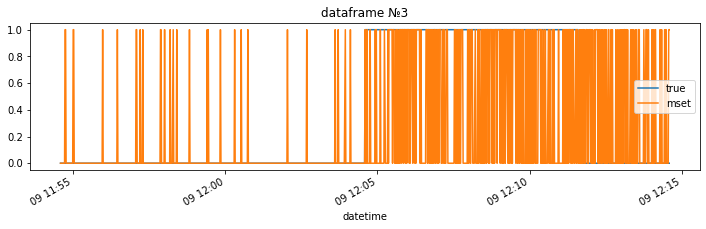

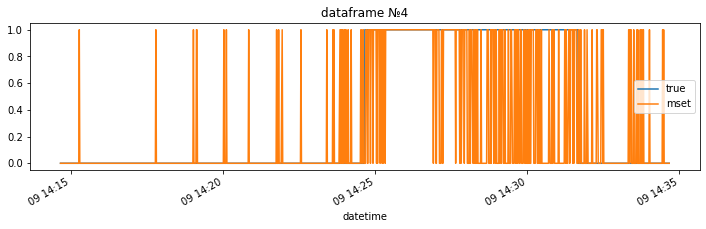

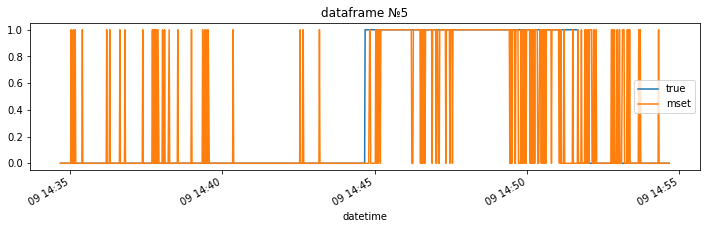

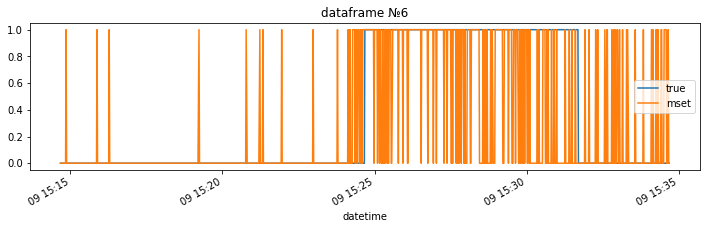

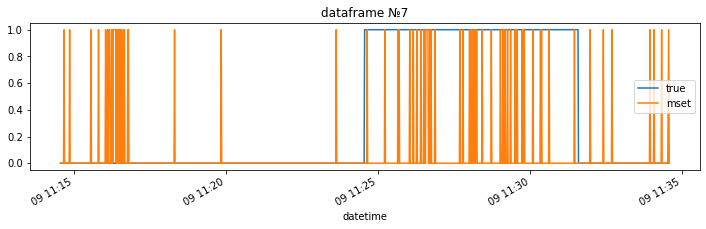

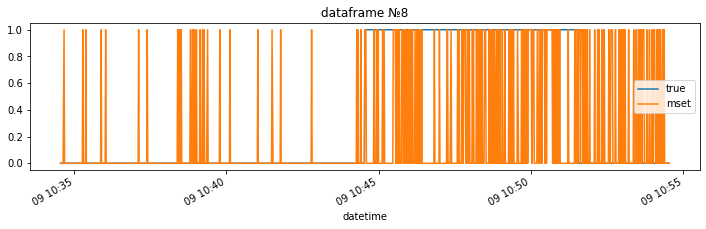

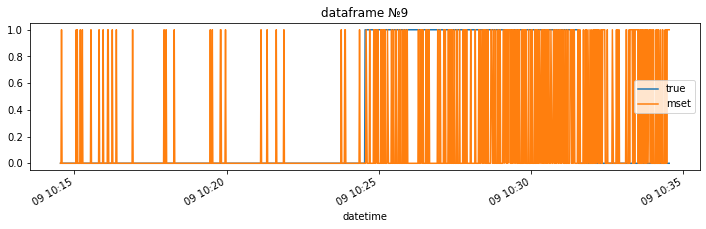

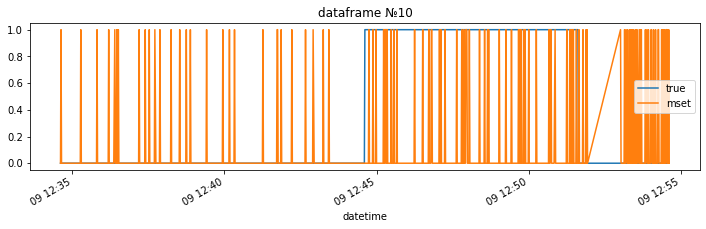

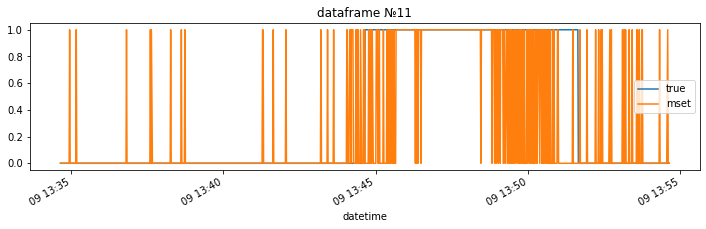

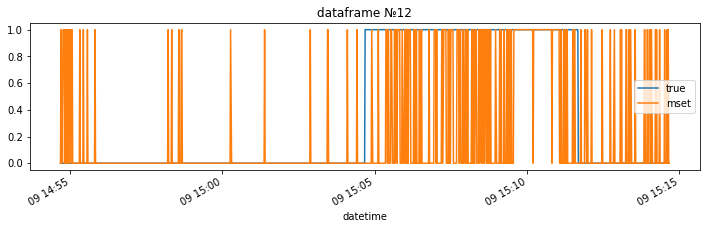

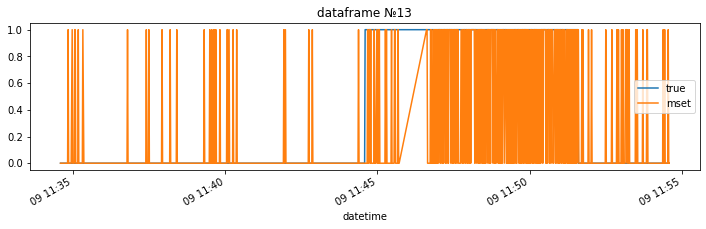

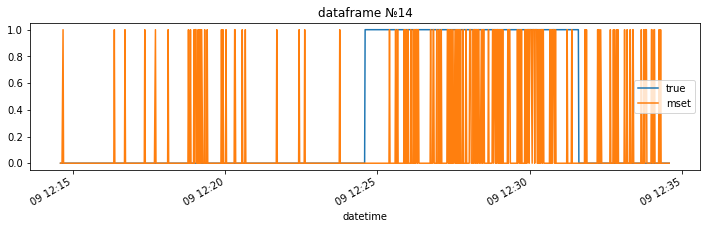

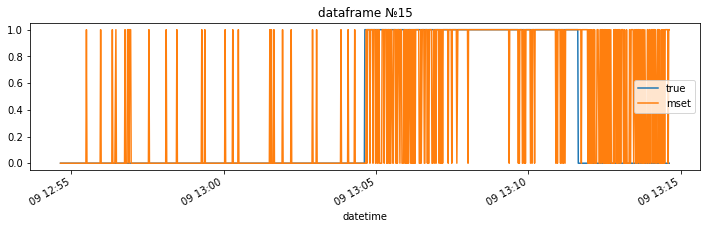

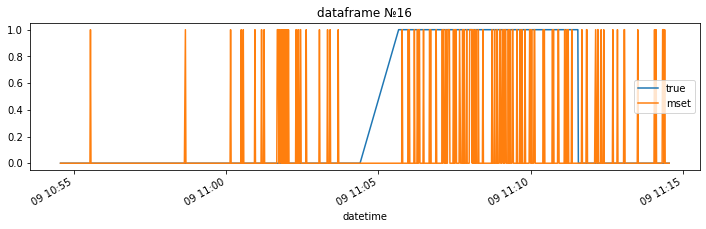

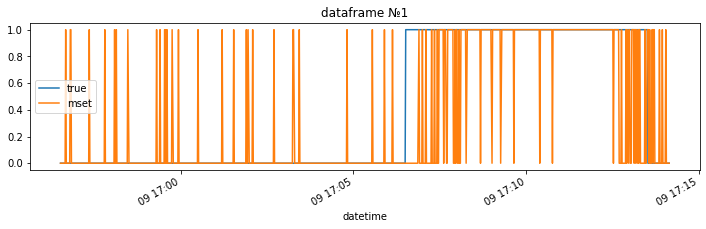

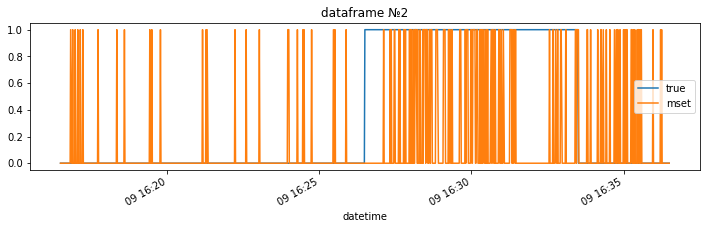

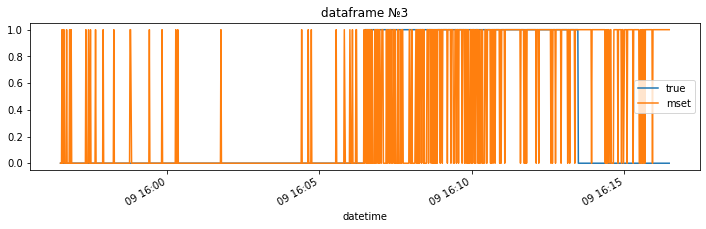

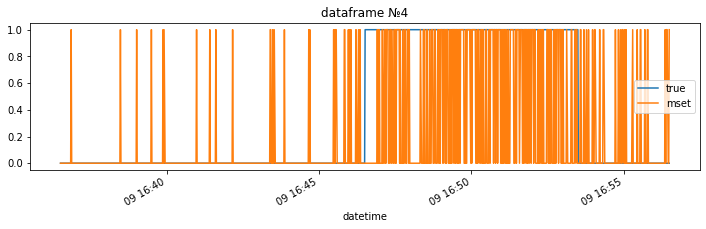

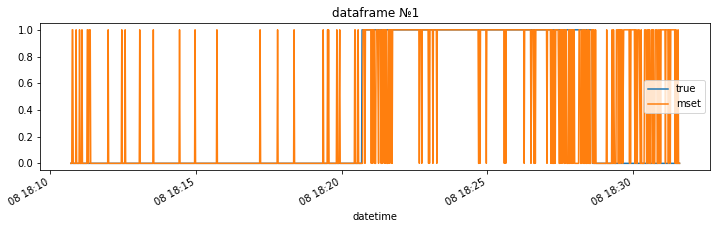

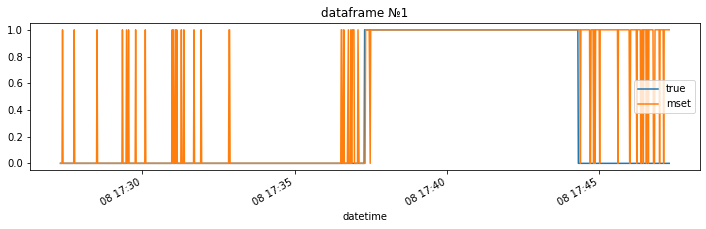

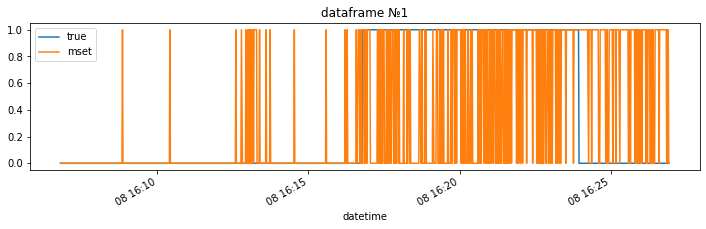

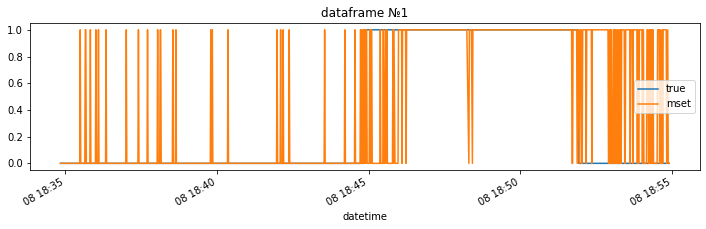

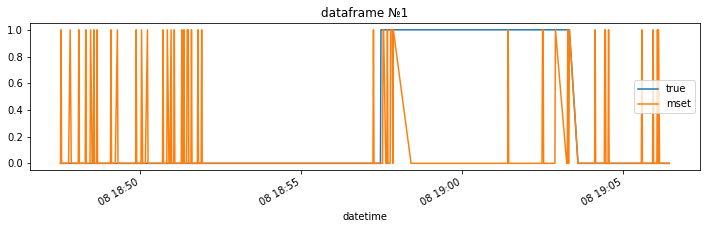

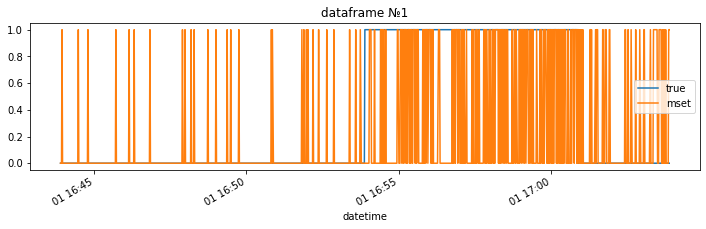

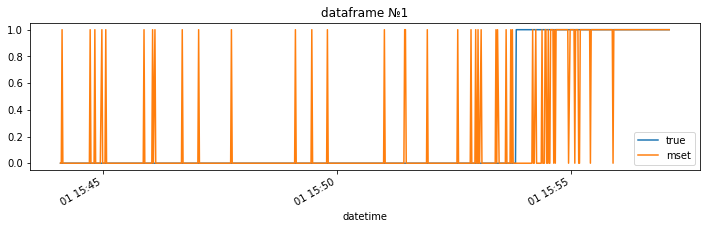

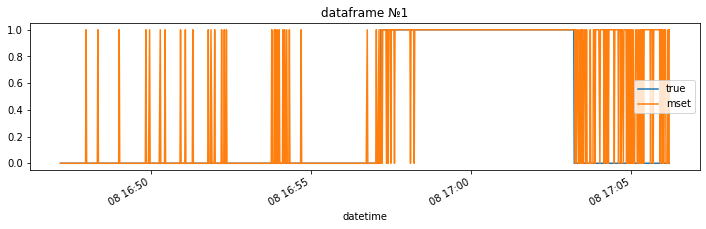

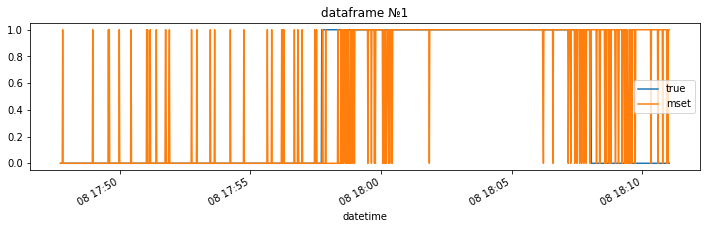

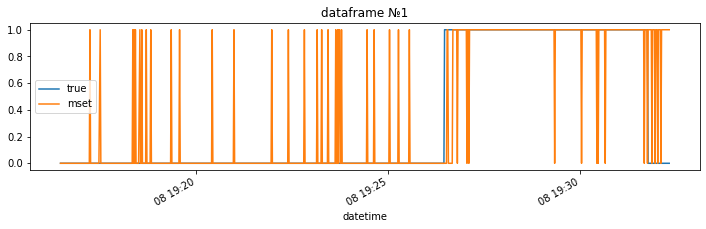

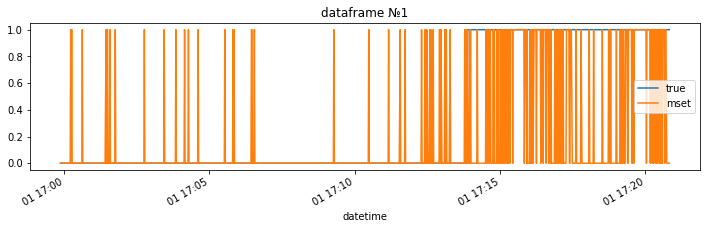

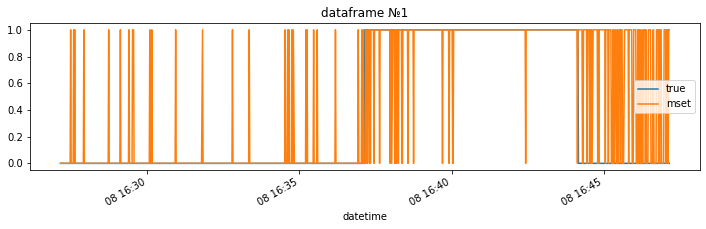

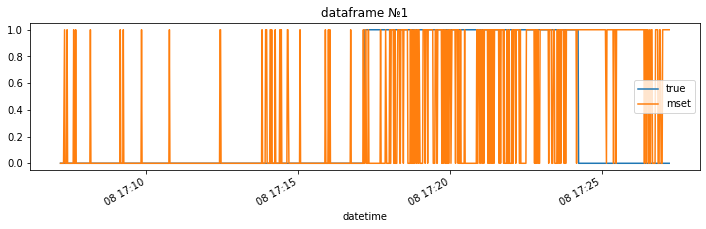

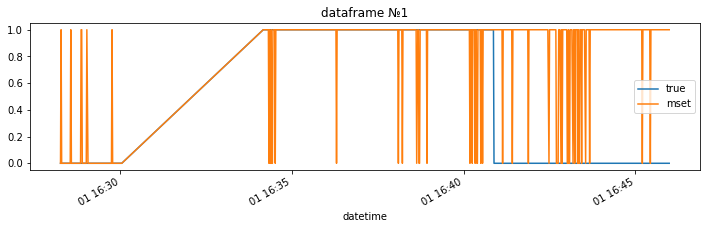

In [5]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = IForest_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [6]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [7]:
from utils.data import show_score_table   
show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.53 | 0.62 | 0.78 | 0.81 | 0.52 | 0.71 | 0.08 | 0.48 | 0.8 | 0.82 | 0.8 | 0.88 | 0.57 | 0.82 | 0.53 | 0.71 | 0.62
FAR |0.09 | 0.12 | 0.16 | 0.24 | 0.23 | 0.2 | 0.05 | 0.1 | 0.05 | 0.19 | 0.23 | 0.09 | 0.05 | 0.19 | 0.24 | 0.69 | 0.13
MAR |0.57 | 0.45 | 0.18 | 0.01 | 0.5 | 0.18 | 0.95 | 0.62 | 0.23 | 0.03 | 0.13 | 0.07 | 0.56 | 0.06 | 0.48 | 0.05 | 0.44